# The Winners' Circle: Ranking Chess' Grandest Of All Time

In [1]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

## Executive Summary

The goal of this report is to analyze the ranking of the top 100 players according to FIDE ratings using PageRank algorithm on the network of matches between the players. The data are extracted from chessgames through web scraping, stored and associated in an SQLite3 database, and processed to calculate for the PageRank using NetworkX library. The results are presented through networks graphs, highlighting key features such as the computed player ranks, the original player FIDE ratings, the competitive years of the players, and their respective regions of origin. The differences between the computed player rankings and the original FIDE rankings were analyzed and presented. 

## Introduction

Chess is such a mentally challenging sport that it is not a stretch to say that its best players are the cream of the crop – the elite of the elite. And yet, even the elite yearns distinction among themselves. The FIDE ratings of the World Chess Federation is the traditional and widely accepted measure for this. It accounts for all the matches of a player, factored in with the respective current ratings of the player and her opponent. The keyword there is “all”, that is, the entire history of competitive matches of the player including the games she played against lower ranked players. So therein lies the crux: what if we only pitted the top players – this elite club – exclusively among each other? Who should then be the really the grandest of the masters? 

## Data Mining and Wrangling

### Data Source

www.chessgames.com is a database of chess players, their matches, the results, and other chess-related information. This site is used in order to scrape the information required for the analysis.

### Web Scraping

In [45]:
# Preliminaries

import urllib.request
import requests
from bs4 import BeautifulSoup
import re
import time
import pandas as pd
import sqlite3
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
import seaborn as sns
%matplotlib inline
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore")

1. Before initializing the scraping, there are a few things to be considered first: the proxy, the database for storage, and the header of the requests.

In [25]:
"""
Initiate proxy, connection to database, and the headers for the requests
"""

import os
os.environ['HTTP_PROXY'] = 'http://13.115.147.132:8080/'
os.environ['HTTPS_PROXY'] = 'http://13.115.147.132:8080/'

conn = sqlite3.connect('/home/msds2020/emedina/dmw/dmw-lab2/chessgames.db')

req_header = """Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3
Accept-Encoding: gzip, deflate
Accept-Language: en-US,en;q=0.9
Cache-Control: max-age=0
Connection: keep-alive
Cookie: __utmc=1; __utmz=1.1558572688.1.1.utmcsr=(direct)|utmccn=(direct)|utmcmd=(none); cookieconsent_status=dismiss; __utma=1.95769001.1558572688.1559485689.1559610428.6; __utmt=1; __utmb=1.1.10.1559610428; _fbp=fb.1.1559610428173.78725876
Host: www.chessgames.com
Upgrade-Insecure-Requests: 1
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36"""

headers = {i.lower(): j for i, j in re.findall(
    "^(.*?): (.*?)$", req_header, re.M)}

2. The list of players were extracted from the site along with the url of their respective site, their highest FIDE rating achieved, and their years of competitive play. This is done for all the players listed in their database. This data is then stored into the `players` table of `chessgames` database.

In [ ]:
"""
Generate the players table containing the player names their page url, the
highest FIDE rating, starting and ending years of competitive play.
"""

df_player = pd.DataFrame()

for initial in list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"):
    print(initial)
    resp = requests.get(
        f'http://www.chessgames.com/directory/{initial}.html', 
        headers=headers)
    soup = BeautifulSoup(resp.text)
    players = soup.select('tr[bgcolor=#FFFFFF],tr[bgcolor=#FFEEDD]')

    df_player_i = pd.DataFrame({
        'name': [p.select("td")[2].text.strip() for p in players],
        'page': [p.select("td")[2].a.get('href') for p in players],
        'rating': [p.select("td")[0].text.strip(u'\xa0') for p in players],
        'years': [p.select("td")[3].text.strip(u'\xa0') for p in players]
    }).sort_values('name').reset_index(drop=True)

    df_player = df_player.append(df_player_i)
    time.sleep(1)

df_player.index = df_player['page'].str.extract(
    'pid=(\d+)', expand=False).rename('player_id')
df_player[['year_start', 'year_end']
          ] = df_player['years'].str.split('-', expand=True)
df_player['year_end'] = df_player.apply(
    lambda row: row['year_end'] if row['year_end'] else row['year_start'], 
    axis=1)
df_player.drop('years', inplace=True, axis=1)

df_player.to_sql("players", conn,
                 dtype={'player_id': 'INT', 'name': 'VARCHAR',
                        'page': 'VARCHAR', 'rating': 'INT', 
                        'year_start': 'INT', 'year_end': 'INT'})

conn.commit()

3. After getting the pages of the players, the matches data was extracted for each player including the opposing players, the result of the game, the number of moves, the event/locale, the year of the event, the opening move, and the game ID. This is then stored into `player_matches` of the `chessgames` database.

In [ ]:
"""
Generate the pages and ids of players with rating higher than 2500 which is
one of the requirements to be a chess grandmaster. Empty lists are also
generated for the pages and players that the scraping will fail.
Comment this chunk of code if we want to pick up from where we left off
"""

cur = conn.cursor()
cur.execute("""SELECT page, player_id FROM players WHERE rating>2500""")
page_players = cur.fetchall()
count = 0
failed_players = []
failed_pages = []

with open('unscraped_players.json', 'w') as outfile:
    json.dump(page_players, outfile)
with open('players_fail.json', 'w') as outfile:
    json.dump(failed_players, outfile)
with open('pages_fail.json', 'w') as outfile:
    json.dump(failed_pages, outfile)

"""
Load the list of players that were unscraped last session and those that
failed to be scraped.
"""

with open('unscraped_players.json') as outfile:
    page_players = json.load(outfile)
with open('players_fail.json') as outfile:
    failed_players = json.load(outfile)
with open('pages_fail.json') as outfile:
    failed_pages = json.load(outfile)
count = 3030 - len(page_players)
page_players_to_add = [
    [i, int(re.search(f'\?pid=(\d+)', i).group(1))] for i in failed_players]
# failed_players[0]
page_players = page_players_to_add + page_players

"""
Actual scraping of the pages of players. Extract the number of pages then
crawl through all the pages to get the results, game ID, and the players.
"""

while page_players:
    page, player_id = page_players[0]
    print(page, player_id)
    while True:
        try:
            resp = requests.get(
                f'http://www.chessgames.com{page}.html', headers=headers)
            if resp.status_code == 200:
                break
            else:
                print(resp.status_code)
        except Exception as e:
            print("TIMEOUT!")
            time.sleep(5)
    try:
        soup = BeautifulSoup(resp.text)
        try:
            last_page = soup.select(
                f"td > a[href$=pid={player_id}] img[src$=end.gif]")[
                0].parent.get('href')
            page_n = re.search(f'(\d+)&pid={player_id}$', last_page).group(1)
        except IndexError:
            page_n = 1
        print(f"{count} out of 3030, {page_n} page/s: {100*count/3030:.2f}%")
        time.sleep(1)
    except Exception as e:
        print("FAIL, player")
        failed_players.append(page)
        time.sleep(1)
        page_players.pop(0)
        continue

    for page_i in range(1, int(page_n)+1):
        while True:
            try:
                resp_page = requests.get(
                    f'http://www.chessgames.com/perl/chess.pl?page={page_i}"
                    f"&pid={player_id}', headers=headers)
                if resp_page.status_code == 200:
                    break
                else:
                    print(resp_page.status_code)
            except Exception as e:
                print("TIMEOUT! inside pageloop")
                time.sleep(5)
        try:
            soup_page = BeautifulSoup(resp_page.text)
            df_i = pd.read_html(str(soup_page.select(
                'table > tr > td > table')[2]), header=0)
                    [0].drop('Unnamed: 1', axis=1)
            df_i[['White', 'Black']] = df_i['Game'].str.extract(
                '\d+\.\\xa0(.*?) vs (.*?)$')
            df_i.drop('Game', axis=1, inplace=True)
            results = {'1-0': 'White', '½-½': 'Draw',
                       '0-1': 'Black', '0-0': 'No Result'}
            df_i['Result'] = df_i['Result'].fillna('0-0')
            df_i['Result'] = df_i['Result'].apply(lambda x: results[x])
            df_i['Game_ID'] = [re.search(f'gid=(\d+)$', game.get('href'))
                               .group(1) for game in soup_page.select(
                                   'a[href^=/perl/chessgame?gid=]')]
            df_i['Player_ID'] = player_id
            df_i.columns = df_i.columns.str.lower()
            df_i.to_sql('player_matches', conn,
                        if_exists='append', index=False)
            time.sleep(1)
        except Exception as e:
            print("FAIL, pages", page_i, player_id)
            failed_pages.append(
                f'http://www.chessgames.com/perl/chess.pl?'
                f'page={page_i}&pid={player_id}')
            time.sleep(1)
            count += 1
            continue
    page_players.pop(0)
    if page in failed_players:
        failed_players.remove(page)
    with open('unscraped_players.json', 'w') as outfile:
        json.dump(page_players, outfile)
    with open('players_fail.json', 'w') as outfile:
        json.dump(failed_players, outfile)
    with open('pages_fail.json', 'w') as outfile:
        json.dump(failed_pages, outfile)
    count += 1
                    
                    
"""
Run the scraping again for the failed pages.
"""

for page in failed_pages.copy():
    print(page)
    while True:
        try:
            resp_page = requests.get(page, headers=headers)
            failed_pages.remove(page)
            break
        except Exception as e:
            print("TIMEOUT! inside pageloop")
            time.sleep(5)
#     try:
    soup_page = BeautifulSoup(resp_page.text)
    df_i = pd.read_html(str(soup_page.select('table > tr > td > table')[
                        2]), header=0)[0].drop('Unnamed: 1', axis=1)
    df_i[['White', 'Black']] = df_i['Game'].str.extract(
        '\d+\.\\xa0(.*?) vs (.*?)$')
    df_i.drop('Game', axis=1, inplace=True)
    results = {'1-0': 'White', '½-½': 'Draw',
               '0-1': 'Black', '0-0': 'No Result'}
    df_i['Result'] = df_i['Result'].fillna('0-0')
    df_i['Result'] = df_i['Result'].apply(lambda x: results[x])
    df_i['Game_ID'] = [re.search(f'gid=(\d+)$', game.get('href')).group(1)
                       for game in 
                       soup_page.select('a[href^=/perl/chessgame?gid=]')]
    df_i['Player_ID'] = player_id
    df_i.columns = df_i.columns.str.lower()
    df_i.to_sql('player_matches', conn, if_exists='append', index=False)
    time.sleep(1)

with open('pages_fail.json', 'w') as outfile:
    json.dump(failed_pages, outfile)

4. To supplement these data, the information of the players were also scraped in one text. The text possibly contains the birthday, deathday, and the place of origin. The text is stored into the `player_info` table of `chessgames` database.

In [ ]:
"""
Create the table player_info
"""

conn.execute("""CREATE TABLE player_info(
            player_id VARCHAR,
            text VARCHAR
            )""")

"""
Get all the players with rating > 2500 (one requirement to be GM)
"""

conn.row_factory = lambda cursor, row: row
cur = conn.cursor()
cur.execute("""SELECT player_id, name, page FROM players 
            WHERE rating>2500""")
player_list = cur.fetchall()

"""
Scrape the text and the player_id from each page
"""

count = 0
for player_id, name, page in player_list:
    print(count)
    try:
        resp = requests.get(
            f"http://www.chessgames.com{page}", headers=headers)
        soup = BeautifulSoup(resp.text)
        text = soup.find_all(
            ['td'], attrs={'align': 'LEFT', 'bgcolor': '#663300'})[0].text
        cur.execute("""INSERT INTO player_info
                    VALUES(?, ?)""", [player_id, text])
        time.sleep(1)
    except IndexError:
        failed_players.append(player_id)
    count += 1
cur.commit()

The database generated can be summarized by this information schema:

<img src="chessgames_db_schema.PNG" width="500" />

### Data Processing

The match data and player data are queried from the created database. Before analyzing the data, some processing were performed:
- The `text` column under `player_info` is processed to extract the age and the country of the player.
- The matches in `player_matches` are filtered such that only matches between two players who are both in the top 100 based on highest FIDE rating achieved. This is to investigate the matches that are only between the best, as part of our analysis.
- Extract the names used in the matches data and the players data and reconcile the formats used.

In [29]:
"""
Combine the players and player_info tables and process the text under 
player_info
"""

cur = conn.cursor()
cur.execute("""SELECT DISTINCT player_id, name, rating, year_start, year_end,
            text FROM players
            JOIN player_info USING(player_id)
            WHERE rating>2500 AND rating<>''
            ORDER BY rating DESC
            LIMIT 100""")
players = cur.fetchall()

players = [(pid, name, elo, t_i, t_o, *re.findall(
    '.*?, (?P<age>\d+).*?\) (?P<country>[\w ]+)', text)[0])
           for pid, name, elo, t_i, t_o, text in players]
players = [(pid, name, elo, t_i, t_o, int(age), country.strip())
           for pid, name, elo, t_i, t_o, age, country in players]
names = [name for _, name, _, _, _, _, _ in players]

In [30]:
"""
Query the matches data from the database between the top 100 players only
"""

cur.execute("""SELECT DISTINCT game_id, result, white, black 
            FROM player_matches
            WHERE game_id IN
            (SELECT game_id FROM 
                (SELECT DISTINCT player_id, game_id FROM player_matches)
                WHERE player_id IN (
                    SELECT player_id FROM players
                    JOIN player_info USING(player_id)
                    WHERE rating>2500 AND rating<>''
                    ORDER BY rating DESC
                    LIMIT 100)
                GROUP BY game_id
                HAVING COUNT(*)>1)
            """)

games = cur.fetchall()

In [31]:
"""
Query the unique player names from the matches data which is different in
format with the player names on the other tables
"""

cur.execute("""SELECT DISTINCT name FROM 
                (SELECT DISTINCT white name FROM player_matches
                WHERE game_id IN
                    (SELECT game_id FROM 
                    (SELECT DISTINCT player_id, game_id FROM player_matches)
                    WHERE player_id IN (
                        SELECT DISTINCT player_id FROM players
                        JOIN player_info USING(player_id)
                        WHERE rating>2500 AND rating<>''
                        ORDER BY rating DESC
                        LIMIT 100)
                    GROUP BY game_id
                    HAVING COUNT(*)>1)
                UNION
                SELECT DISTINCT black name FROM player_matches
                WHERE game_id IN
                    (SELECT game_id FROM 
                    (SELECT DISTINCT player_id, game_id FROM player_matches)
                    WHERE player_id IN (
                        SELECT DISTINCT player_id FROM players
                        JOIN player_info USING(player_id)
                        WHERE rating>2500 AND rating<>''
                        ORDER BY rating DESC
                        LIMIT 100)
                    GROUP BY game_id
                    HAVING COUNT(*)>1))
            """)

top_players = cur.fetchall()


### Data Analysis

In order to analyse the relationships between the players in the FIDE top 100, their net wins between each other are characterized as a network, $W$. The number of wins each player has over each other was converted into $100\times100$ array $A$ of wins where $A_{ij}$ is the number of wins player $i$ has over player $j$. From this, the net win matrix $W$ was constructed using:

$$W_{ij} = \begin{cases} 
  0, & \text{if }A_{ij}\leq A_{ji} \\
  A_{ij} - A_{ji}, & \text{if } A_{ij}>A_{ji}\\
\end{cases}$$
where $i$, $j$ are the players with the highest achieved FIDE ratings.

After that, the players that had no net win over any other player in the top 100 were removed from the matrix since they would offer no contribution to the analysis. A network was then constructed using that as adjacency matrix.

In [32]:
"""
Add the player ID of the opposing players in the matches data
"""

p1 = [(pid, name.split(',')[0].split()[-1].upper())
      for pid, name, _, _, _, _, _ in players]
pid, surnames = list(zip(*p1))
p2 = []
for gid, result, white, black in games:
    try:
        p2.append((gid, result, white, pid[surnames.index(white.split(
        )[-1].upper())], black,
            pid[surnames.index(black.split()[-1].upper())]))
    except ValueError:
        pass

"""
Construct a winmatrix W between the top 100 players where W_ij is the number
of wins player i has over j
"""

winmat = np.zeros((len(top_players), len(top_players)))

for _, result, whitename, whiteid, blackname, blackid in p2:
    if result == 'White':
        winmat[pid.index(whiteid), pid.index(blackid)] += 1
    elif result == 'Black':
        winmat[pid.index(blackid), pid.index(whiteid)] += 1
    elif result == 'Draw':
        winmat[pid.index(whiteid), pid.index(blackid)] += 0.5
        winmat[pid.index(blackid), pid.index(whiteid)] += 0.5
        
"""
Convert the winmatrix to a net win matrix where the values of the matrix are
now the net number of wins one player has over the other.
"""

for i in range(len(winmat)):
    for j in range(i+1, len(winmat)):
        if winmat[i, j] >= winmat[j, i]:
            winmat[i, j] = winmat[i, j] - winmat[j, i]
            winmat[j, i] = 0
        else:
            winmat[j, i] = winmat[j, i] - winmat[i, j]
            winmat[i, j] = 0
            
"""
Remove the players that do not have a net win over the other players
"""

_, names, rating, years, _, _, region = list(zip(*players))
names = list(names)
i = 0
pid = list(pid)
rating = list(rating)
names_popped = []
while i < len(winmat):
    if winmat[i].sum() == 0:
        winmat = np.delete(winmat, i, 1)
        winmat = np.delete(winmat, i, 0)
        pid.pop(i)
        rating.pop(i)
        names_popped.append(names[i])
        names.pop(i)
    else:
        i += 1
        
"""
Construct the network and calculate the PageRank
"""

G = nx.from_numpy_matrix(winmat)
d = 1
pr = nx.pagerank(G, alpha=d)

"""
Rescale the PageRank values for visualization
"""

scaled_pr = np.array(list(pr.values()))
scaled_pr = np.array(list(map(lambda x: x**2, scaled_pr)))

scaled_pr = scaled_pr/max(scaled_pr)

"""
Create a dataframe containing the players' information, along with their
FIDE rating and PageRank
"""

df_players = pd.DataFrame(players)
df_rank = pd.DataFrame(
    list(zip(names, np.array(list(pr.values()))/max(list(pr.values())))))
df_merge = pd.merge(df_players, df_rank, how='outer', left_on=1,
                    right_on=0).drop(['0_x', 4, 5, '0_y', '1_x'], axis=1)
df_merge.columns = ['Name', 'FIDE Rating',
                    'Year Started', 'Region', 'PageRank']
df_merge['Rank (FIDE)'] = df_merge.index + 1
df_merge = df_merge.sort_values(
    'PageRank', ascending=False).reset_index(drop=True)
df_merge['Rank (PageRank)'] = df_merge.index + 1
df_merge['Change'] = df_merge['Rank (PageRank)'] - df_merge['Rank (FIDE)']


def f(x):
    if x > 0:
        return '+'
    elif x < 0:
        return '-'
    else:
        return '0'


df_merge['Change'] = df_merge['Change'].apply(f)
df_merge['PageRank'] = np.round(df_merge['PageRank'], 2)

To analyze the relationship of the players, the PageRank measure was used. Using PageRank as the rank metric, one can quantify the skill level of a player based on the players they defeat. A damping factor of $1$ was used in the PageRank algorithm as the net win matrix has no dependence on random element, i.e. the PageRank of a player is purely dependent on the PageRank of the other players defeated by him/her.

## Results and Discussion

The calculated player ranks are plotted against their (I) their respective highest FIDE ratings obtained; (II) the years at which they started competitive plays; (III) and their regions of origin; as well the notable inter-players match connections salient to the ranking of the top ranked players. 

### I. Player Ranks vs FIDE Ratings

In [33]:
"""
Get the index of the top-ranked players with respect to PageRank
"""

top5ranked = np.argsort(scaled_pr)[::-1][:5]
top20ranked = np.argsort(scaled_pr)[::-1][:20]
bottop20ranked = np.argsort(scaled_pr)[::-1][10:20]

In [34]:
"""
Create an edge_width list based on ranking for the network visualization
"""

edge_width = []
idx = 0
for i, j in G.edges():
    if i == top5ranked[0] and (j in top20ranked):
        edge_width.append(4)
    elif i == top5ranked[1] and (j in top20ranked):
        edge_width.append(3)
    elif i == top5ranked[2] and (j in top20ranked):
        edge_width.append(2)
    elif i == top5ranked[3] and (j in top20ranked):
        edge_width.append(1)
    elif i == top5ranked[4] and (j in top20ranked):
        edge_width.append(0.5)
    else:
        edge_width.append(0.25)

edge_width[-1] = 0

In [35]:
"""
Create a mapping for the node labels in the network visualization
"""

names_short = [re.search('[A-Z ,]+', name).group(0) for name in names]
mapping = {i: (j if i in top20ranked else ' ')
           for i, j in zip(range(len(G.nodes())), names_short)}

The following Networkx graph shows the nodes as the players which are: (a) arranged counter-clockwise according to decreasing FIDE ratings (I.e, the top FIDE-rated player starts at the 90 deg point), (b) colored according to their FIDE rating; (c) sized according to their scaled and normalized page ranks; and (d) drawn with edges indicating the top players net wins against the other top players.  

What is immediately apparent here is the finding that the computed ranks do not consistently correspond to the plyers’ highest FIDE ratings. There are smaller computed ranks for some higher rated players, while there are also a few players at the latter end of FIDE ratings which have higher computed ranks. Interestingly, and perhaps expectedly too, Magnus Carlsen is the top player in both terms of the FIDE ratings and computed ranks. 

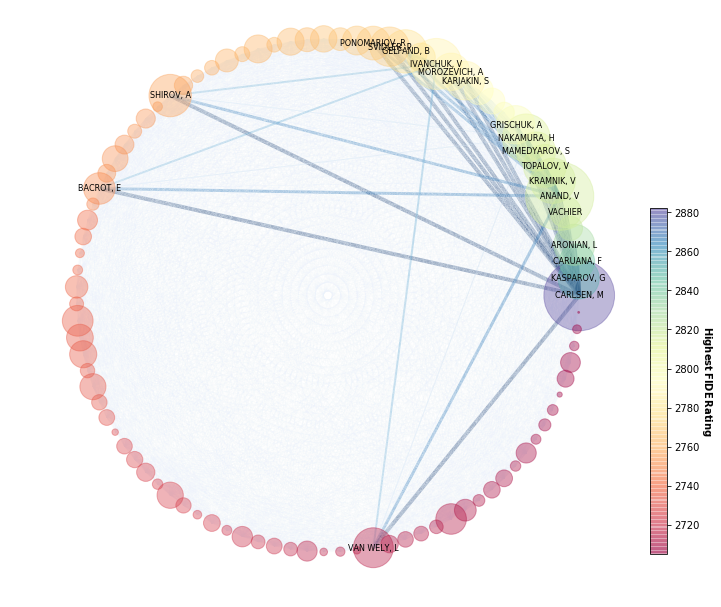

In [36]:
"""
Draw the network
"""

fig = plt.figure(figsize=(8, 8));
cmap = plt.cm.Spectral;
pos = nx.drawing.layout.circular_layout(G);

nx.draw(G, alpha=0.4, node_color=rating, cmap=cmap, node_size=5000*scaled_pr,
        pos=pos, with_labels=False, width=np.array(edge_width), 
        edge_color=edge_width, edge_cmap=plt.cm.Blues);
nx.draw_networkx_labels(G, pos, labels=mapping, font_size=8, font_color='k');

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
    vmin=min(rating), vmax=max(rating)));
sm._A = []
cbar = plt.colorbar(sm, cax=fig.add_axes([1.05, 0.05, 0.03, 0.6]), alpha=0.4);
cbar.ax.set_ylabel(r"$\bf{Highest\,FIDE\,Rating}$", labelpad=15, 
                   rotation=270);

In [37]:
"""
Create an edge_width list based on ranking for the network visualization
"""

edge_width = []
idx = 0
for i, j in G.edges():
    if i == bottop20ranked[0] and (j in top20ranked):
        edge_width.append(4)
    elif i == bottop20ranked[1] and (j in top20ranked):
        edge_width.append(3)
    elif i == bottop20ranked[2] and (j in top20ranked):
        edge_width.append(2)
    elif i == bottop20ranked[3] and (j in top20ranked):
        edge_width.append(1)
    elif i == bottop20ranked[4] and (j in top20ranked):
        edge_width.append(0.5)
    else:
        edge_width.append(0.25)
        
edge_width[-1] = 0

The discrepancy can be largely explained by two main things. First, the model limits the matches to those exclusively played between the top players. This means that the matches the players against players outside the “winners’ circle" - which contributed to their FIDE rating – are not accounted. Second, the page rank algorithm does not only take account the total net wins of the players, but their net wins against higher ranked players. This means that the player’s rank gets a significant boost if they had outmatched even a few of the higher ranked players. This is best illustrated in the following Networkx graph which now highlights the edges or “net wins" of the top 11-20 ranked players. These players are ranked higher because of 1 or 2 net wins against top players. 

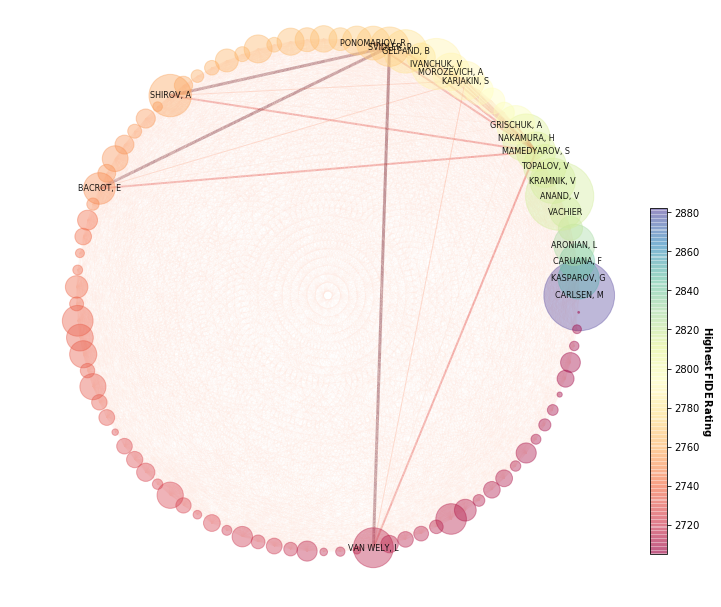

In [38]:
"""
Draw the network
"""

fig = plt.figure(figsize=(8, 8))
cmap = plt.cm.Spectral
pos = nx.drawing.layout.circular_layout(G)
nx.draw(G, alpha=0.4, node_color=rating, cmap=cmap, node_size=5000*scaled_pr,
        pos=pos, with_labels=False, width=np.array(edge_width), 
        edge_color=edge_width, edge_cmap=plt.cm.Reds)
nx.draw_networkx_labels(G, pos, labels=mapping,
                        font_size=8, font_color='k', alpha=0.9)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
    vmin=min(rating), vmax=max(rating)))
sm._A = []
cbar = plt.colorbar(sm, cax=fig.add_axes([1.05, 0.05, 0.03, 0.6]), alpha=0.4)
cbar.ax.set_ylabel(r"$\bf{Highest\,FIDE\,Rating}$", labelpad=15, 
                   rotation=270);

The distribution of the difference between the rankings based on the FIDE ratings and the computed rankings are shown below. The differences as shown in the plot closely approximates normal distribution. The mean of the difference – which is expected at 0 – is also at the peak point of the distribution. On the other hand, the standard deviation at ~22, indicates a significant spread on the difference. Lastly, the total number of elements at the positive side or those with net gain (rank > FIDE rating) is almost equal as well to those in negative side. 

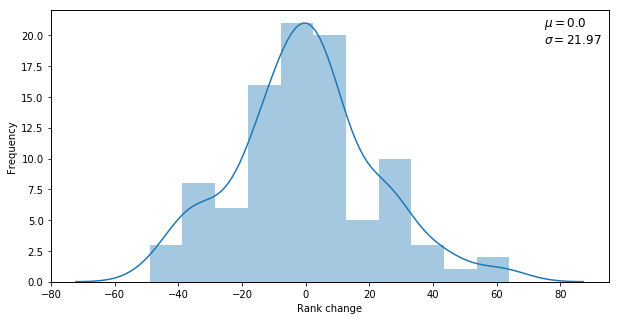

In [44]:
"""
Get the rank change between the FIDE and the PageRank
"""

diff = np.argsort(scaled_pr)[::-1] - np.arange(len(scaled_pr))
fig,ax1 = plt.subplots(figsize=(10,5))
sns.distplot(diff,kde=False,ax=ax1)
ax2 = ax1.twinx()
ax2.yaxis.set_ticks([])
sns.kdeplot(diff,ax=ax2)
ax1.set_xlabel("Rank change")
ax1.set_ylabel("Frequency")

ax1.text(75, 19.5, r"$\mu = %s$"%np.mean(diff) + 
         "\n" + r"$\sigma = %.2f$"%np.std(diff),fontsize=12);

### II. Player Ranks vs Start Year of Competitive Play

In [18]:
"""
Investigate the year the players started competing
"""

p1 = [(pid, name.split(',')[0].split()[-1].upper())
      for pid, name, _, _, _, _, _ in players]
pid, surnames = list(zip(*p1))
p2 = []
for gid, result, white, black in games:
    try:
        p2.append((gid, result, white, pid[surnames.index(white.split(
        )[-1].upper())], black, 
                   pid[surnames.index(black.split()[-1].upper())]))
    except ValueError:
        pass

winmat = np.zeros((len(top_players), len(top_players)))
pid = list(np.array(pid)[np.argsort(years)])
for _, result, whitename, whiteid, blackname, blackid in p2:
    if result == 'White':
        winmat[pid.index(whiteid), pid.index(blackid)] += 1
    elif result == 'Black':
        winmat[pid.index(blackid), pid.index(whiteid)] += 1
    elif result == 'Draw':
        winmat[pid.index(whiteid), pid.index(blackid)] += 0.5
        winmat[pid.index(blackid), pid.index(whiteid)] += 0.5

for i in range(len(winmat)):
    for j in range(i+1, len(winmat)):
        if winmat[i, j] >= winmat[j, i]:
            winmat[i, j] = winmat[i, j] - winmat[j, i]
            winmat[j, i] = 0
        else:
            winmat[j, i] = winmat[j, i] - winmat[i, j]
            winmat[i, j] = 0

_, names, rating, years, _, _, region = list(zip(*players))
names = np.array(names)[np.argsort(years)]

i = 0
pid = list(pid)
years = list(years)
names = list(names)
while i < len(winmat):
    if winmat[i].sum() == 0:
        winmat = np.delete(winmat, i, 1)
        winmat = np.delete(winmat, i, 0)
        pid.pop(i)
        years.pop(i)
        names.pop(i)
    else:
        i += 1

G = nx.from_numpy_matrix(winmat)
d = 1
pr = nx.pagerank(G, alpha=d)

scaled_pr = np.array(list(pr.values()))
scaled_pr = np.array(list(map(lambda x: x**2, scaled_pr)))

scaled_pr = scaled_pr/max(scaled_pr)

top5ranked = np.argsort(scaled_pr)[::-1][:5]
top20ranked = np.argsort(scaled_pr)[::-1][:20]
bottop20ranked = np.argsort(scaled_pr)[::-1][10:20]

edge_width = []
idx = 0
for i, j in G.edges():
    if i == top5ranked[0] and (j in top20ranked):
        edge_width.append(4)
    elif i == top5ranked[1] and (j in top20ranked):
        edge_width.append(3)
    elif i == top5ranked[2] and (j in top20ranked):
        edge_width.append(2)
    elif i == top5ranked[3] and (j in top20ranked):
        edge_width.append(1)
    elif i == top5ranked[4] and (j in top20ranked):
        edge_width.append(0.5)
    else:
        edge_width.append(0.25)

edge_width[-1] = 0

mapping = {i: (j if i in np.argsort(scaled_pr)[
               ::-1][:20] else ' ') for i, j in zip(range(len(G.nodes())),
                                                    names)}

Another perspective investigated is when the players are sorted according to the years they started playing competitive games. There are considerably larger densities of top players found during in late-1970s to early-1980s and the late-1990s. This appears to indicate the “golden generations” of chess grandmasters at these times. 

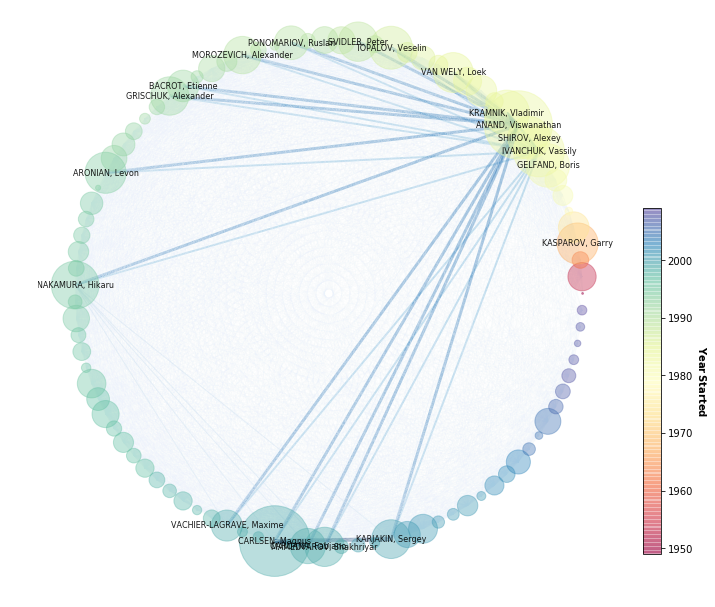

In [19]:
"""
Draw the network
"""

fig = plt.figure(figsize=(8, 8))
cmap = plt.cm.Spectral
pos = nx.drawing.layout.circular_layout(G)
nx.draw(G, alpha=0.4, node_color=sorted(years), cmap=cmap,
        node_size=5000*scaled_pr, pos=pos, with_labels=False,
        width=np.array(edge_width), edge_color=edge_width,
        edge_cmap=plt.cm.Blues)
nx.draw_networkx_labels(G, pos, labels=mapping,
                        font_size=8, font_color='k', alpha=0.9)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
    vmin=min(years), vmax=max(years)))
sm._A = []
cbar = plt.colorbar(sm, cax=fig.add_axes([1.05, 0.05, 0.03, 0.6]), alpha=0.4)
cbar.ax.set_ylabel(r"$\bf{Year\,Started}$", labelpad=15, rotation=270);

### III. Player Ranks vs Regions of Origin 

In [20]:
"""
Investigate the regions the players came from
"""

ctr_reg = {'Armenia': 'Eastern Europe',
           'Azerbaijan': 'Eastern Europe',
           'Belarus': 'Eastern Europe',
           'Bosnia and Herzegovina': 'Eastern Europe',
           'Bulgaria': 'Eastern Europe',
           'China': 'Asia',
           'Cuba': 'Latin America',
           'Czech Republic': 'Eastern Europe',
           'France': 'Western Europe',
           'Georgia': 'Eastern Europe',
           'Hungary': 'Western Europe',
           'India': 'Asia',
           'Japan': 'Asia',
           'Kyrgyzstan': 'Asia',
           'Latvia': 'Eastern Europe',
           'Moldova': 'Eastern Europe',
           'Netherlands': 'Western Europe',
           'Norway': 'Western Europe',
           'Philippines': 'Asia',
           'Poland': 'Western Europe',
           'Romania': 'Eastern Europe',
           'Russia': 'Eastern Europe',
           'Spain': 'Western Europe',
           'Ukraine': 'Eastern Europe',
           'United Kingdom': 'Western Europe',
           'United States of America': 'North America',
           'Uzbekistan': 'Eastern Europe',
           'Vietnam': 'Asia'}

_, names, rating, years, _, _, region = list(zip(*players))

ctr = [ctr_reg[i] for i in region]
names = list(np.array(names)[np.argsort(ctr)])
ctr_unique = np.unique(ctr)
ctr_n = [np.where(ctr_unique == i)[0][0] for i in ctr]

p1 = [(pid, name.split(',')[0].split()[-1].upper())
      for pid, name, _, _, _, _, _ in players]
pid, surnames = list(zip(*p1))
p2 = []
for gid, result, white, black in games:
    try:
        p2.append((gid, result, white, pid[surnames.index(white.split(
        )[-1].upper())], black,
            pid[surnames.index(black.split()[-1].upper())]))
    except ValueError:
        pass

winmat = np.zeros((len(top_players), len(top_players)))
pid = list(np.array(pid)[np.argsort(ctr)])

for _, result, whitename, whiteid, blackname, blackid in p2:
    if result == 'White':
        winmat[pid.index(whiteid), pid.index(blackid)] += 1
    elif result == 'Black':
        winmat[pid.index(blackid), pid.index(whiteid)] += 1
    elif result == 'Draw':
        winmat[pid.index(whiteid), pid.index(blackid)] += 0.5
        winmat[pid.index(blackid), pid.index(whiteid)] += 0.5

for i in range(len(winmat)):
    for j in range(i+1, len(winmat)):
        if winmat[i, j] >= winmat[j, i]:
            winmat[i, j] = winmat[i, j] - winmat[j, i]
            winmat[j, i] = 0
        else:
            winmat[j, i] = winmat[j, i] - winmat[i, j]
            winmat[i, j] = 0

i = 0
pid = list(pid)
while i < len(winmat):
    if winmat[i].sum() == 0:
        winmat = np.delete(winmat, i, 1)
        winmat = np.delete(winmat, i, 0)
        pid.pop(i)
        ctr.pop(i)
        ctr_n.pop(i)
        names.pop(i)
    else:
        i += 1

G = nx.from_numpy_matrix(winmat)
d = 1
pr = nx.pagerank(G, alpha=d)

scaled_pr = np.array(list(pr.values()))
scaled_pr = np.array(list(map(lambda x: x**2, scaled_pr)))

scaled_pr = scaled_pr/max(scaled_pr)

top5ranked = np.argsort(scaled_pr)[::-1][:5]
top20ranked = np.argsort(scaled_pr)[::-1][:20]
bottop20ranked = np.argsort(scaled_pr)[::-1][10:20]

edge_width = []
idx = 0
for i, j in G.edges():
    if i == top5ranked[0] and (j in top20ranked):
        edge_width.append(4)
    elif i == top5ranked[1] and (j in top20ranked):
        edge_width.append(3)
    elif i == top5ranked[2] and (j in top20ranked):
        edge_width.append(2)
    elif i == top5ranked[3] and (j in top20ranked):
        edge_width.append(1)
    elif i == top5ranked[4] and (j in top20ranked):
        edge_width.append(0.5)
    else:
        edge_width.append(0.25)

edge_width[-1] = 0

mapping = {i: (j if i in np.argsort(scaled_pr)[
               ::-1][:20] else ' ') for i, j in zip(G.nodes(), names)}

Finally, the players are likewise plotted and grouped according to their region of origin, i.e., Western or Eastern Europe, North or Latin America, and Asia. The top players are mostly from Eastern Europe, but the highest rank players came from Western Europe and Asia. There are few top players from the Americas, while none are from Africa and Australia. 

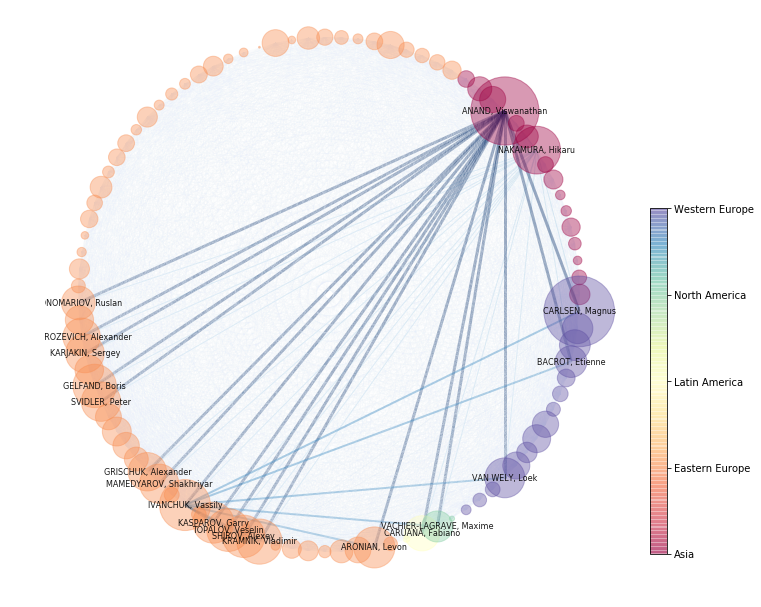

In [21]:
fig = plt.figure(figsize=(8, 8))
cmap = plt.cm.Spectral
pos = nx.drawing.layout.circular_layout(G)
nx.draw(G, alpha=0.4, node_color=sorted(ctr_n), cmap=cmap,
        node_size=5000*scaled_pr, pos=pos, with_labels=False,
        width=np.array(edge_width), edge_color=edge_width,
        edge_cmap=plt.cm.Blues)
nx.draw_networkx_labels(G, pos, labels=mapping,
                        font_size=8, font_color='k', alpha=0.9)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
    vmin=min(ctr_n), vmax=max(ctr_n)))
sm._A = []
cbar = plt.colorbar(sm, cax=fig.add_axes([1.05, 0.05, 0.03, 0.6]), alpha=0.4)
cbar.ax.get_yaxis().set_ticks(range(len(ctr_unique)))
cbar.ax.get_yaxis().set_ticklabels(ctr_unique);

## Conclusions

Comparing the FIDE rankings with the calculated player rankings, there were significant difference in the rankings. This can be attributed to limiting the matches to those played exclusively between the top FIDE ranked players, and the PageRank algorithm gives more weight on the connections (i.e. net wins) of lower ranked players against higher ranked players. Despite these, Magnus Carlsen, FIDE's current number 1, still emerged on top of the computed rankings.

Additional interesting findings are: there appears to be "golden generations" of players, as seen from the denser grouping of high ranked players at particular timeframes, and most of the top ranked players were from Eastern Europe.

## Appendix

The table below shows the players, their FIDE ratings, the year they started competing, the region where they came from, their PageRank, the rank based on PageRank, and the change (positive, negative, or no change).

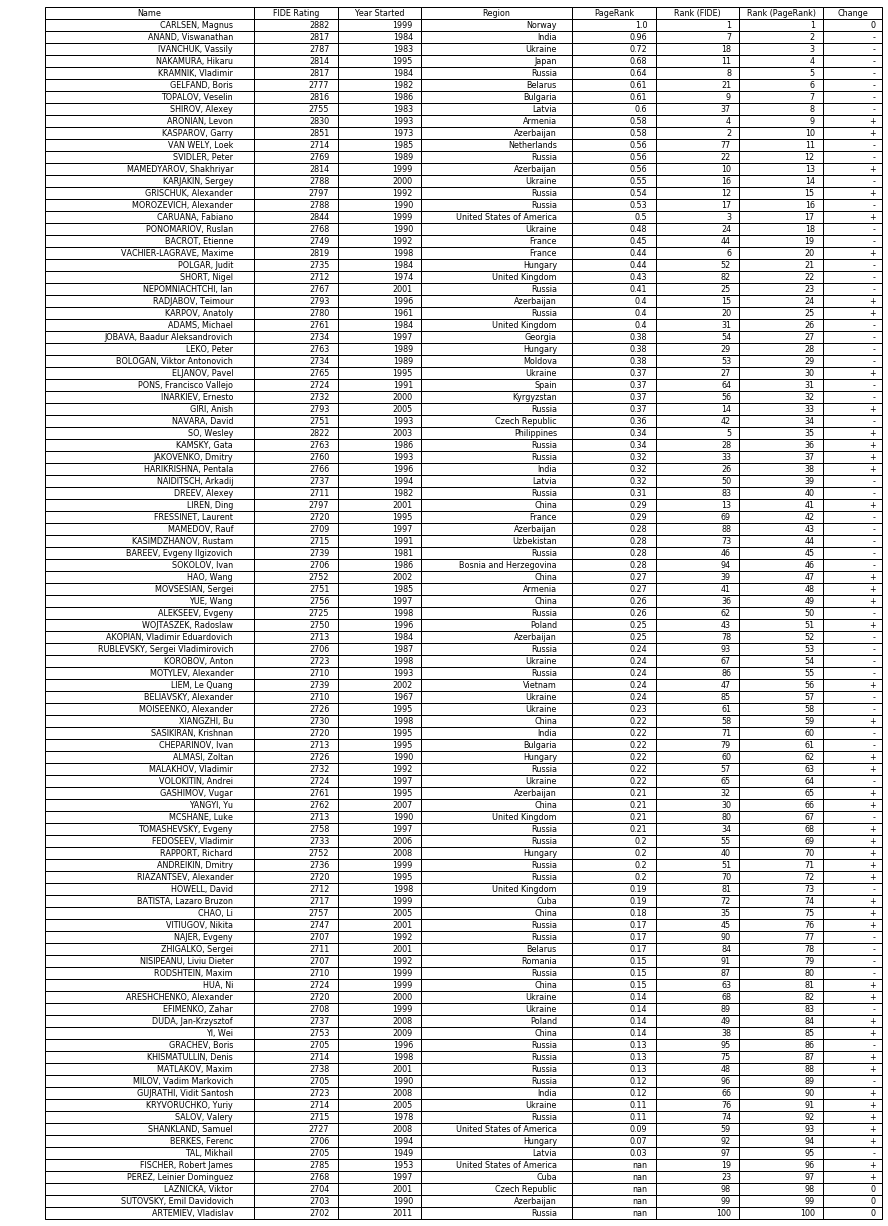

In [22]:
fig, ax = plt.subplots(figsize=(15,20))

ax.axis('off')
ax.axis('tight')

ax.table(cellText=df_merge.values, colLabels=df_merge.columns, loc='center',
        colWidths=[0.25, 0.1, 0.1, 0.18, 0.1, 0.1, 0.1, 0.07]);

## Reference

[1] FIDE calculator, https://ratings.fide.com/calculators.phtml 